In [10]:
import zipfile

!unzip /content/drive/MyDrive/a2.zip -d /content/a_1

Streaming output truncated to the last 5000 lines.
  inflating: /content/a_1/nonsegmentedv2/Charlock/308.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/309.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/31.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/310.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/311.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/312.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/313.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/314.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/315.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/316.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/317.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/318.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/319.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/32.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/320.png  
  inflating: /content/a_1/nonsegmentedv2/Charlock/3

In [16]:
import os

path = "/content/a_1"
image_count = sum(len(files) for _, _, files in os.walk(path))

print(f"Total number of images: {image_count}")


Total number of images: 11078


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import seaborn as sns
import tensorflow as tf

In [11]:
data_dir = '/content/a_1'

In [14]:
class_names = sorted(os.listdir(data_dir))
print("Classes:", class_names)

image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in class_names}
print("Number of images per class:", image_counts)

Classes: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'ShepherdтАЩs Purse', 'Small-flowered Cranesbill', 'Sugar beet', 'nonsegmentedv2']
Number of images per class: {'Black-grass': 309, 'Charlock': 452, 'Cleavers': 335, 'Common Chickweed': 713, 'Common wheat': 253, 'Fat Hen': 538, 'Loose Silky-bent': 762, 'Maize': 257, 'Scentless Mayweed': 607, 'ShepherdтАЩs Purse': 274, 'Small-flowered Cranesbill': 576, 'Sugar beet': 463, 'nonsegmentedv2': 12}


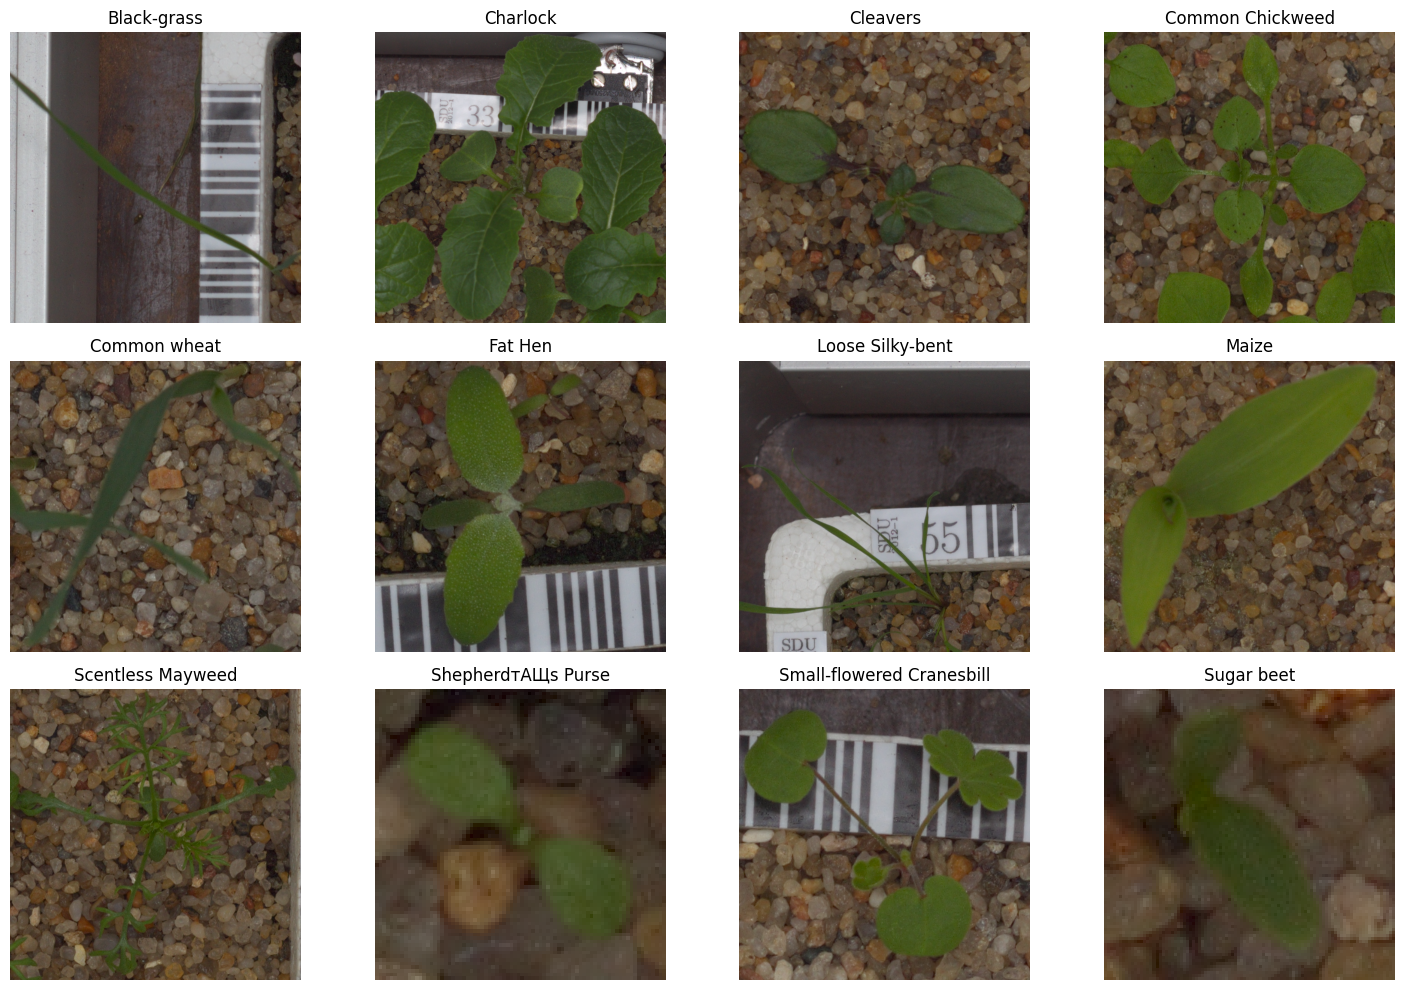

In [15]:
def plot_sample_images(data_dir, class_names, num_samples=1):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()

    for idx, class_name in enumerate(class_names[:12]):
        image_folder = os.path.join(data_dir, class_name)
        image_files = glob(os.path.join(image_folder, "*.png"))

        if image_files:  # Ensure there is at least one image in the folder
            img = Image.open(image_files[0])
            axes[idx].imshow(img)
            axes[idx].set_title(class_name)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(data_dir, class_names)


In [17]:
IMG_SIZE = (128, 128)

def load_images(data_dir, class_names, img_size=IMG_SIZE):
    images, labels = [], []

    for label, class_name in enumerate(class_names[:12]):
        folder_path = os.path.join(data_dir, class_name)
        image_files = glob(os.path.join(folder_path, "*.png"))

        for file in image_files:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size) / 255.0  # Normalize while resizing

            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

images, labels = load_images(data_dir, class_names)

print(f"Image dataset shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Image dataset shape: (5539, 128, 128, 3)
Labels shape: (5539,)


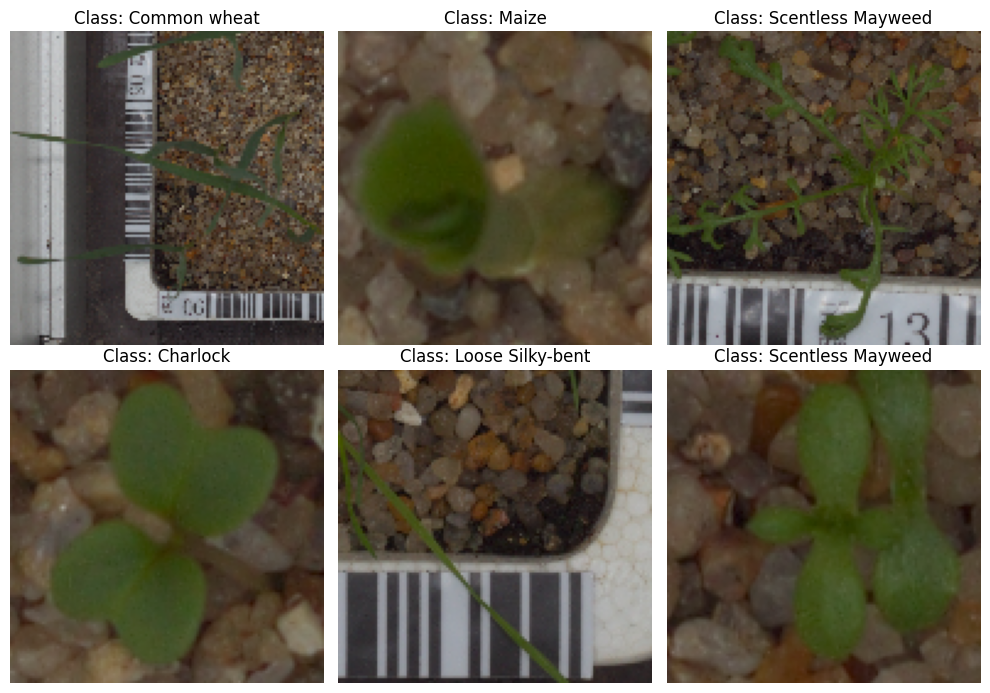

In [18]:
def plot_preprocessed_images(images, labels, class_names, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(10, 7))
    axes = axes.flatten()

    selected_indices = np.random.choice(range(len(images)), num_samples, replace=False)

    for i, img_idx in enumerate(selected_indices):
        axes[i].imshow(images[img_idx])
        axes[i].set_title(f"Class: {class_names[labels[img_idx]]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

plot_preprocessed_images(images, labels, class_names)

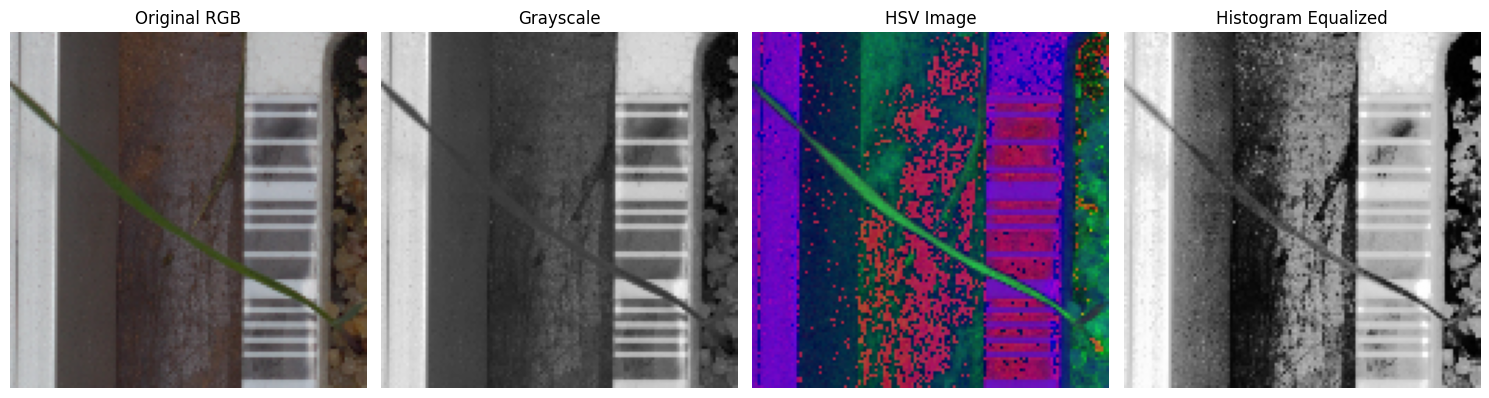

In [20]:
sample_img = images[0]

gray_img = cv2.cvtColor((sample_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
hsv_img = cv2.cvtColor((sample_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
equalized_img = cv2.equalizeHist(gray_img)

# Display images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(sample_img)
axes[0].set_title("Original RGB")
axes[0].axis('off')

axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Grayscale")
axes[1].axis('off')

axes[2].imshow(hsv_img)
axes[2].set_title("HSV Image")
axes[2].axis('off')

axes[3].imshow(equalized_img, cmap='gray')
axes[3].set_title("Histogram Equalized")
axes[3].axis('off')

plt.tight_layout()
plt.show()


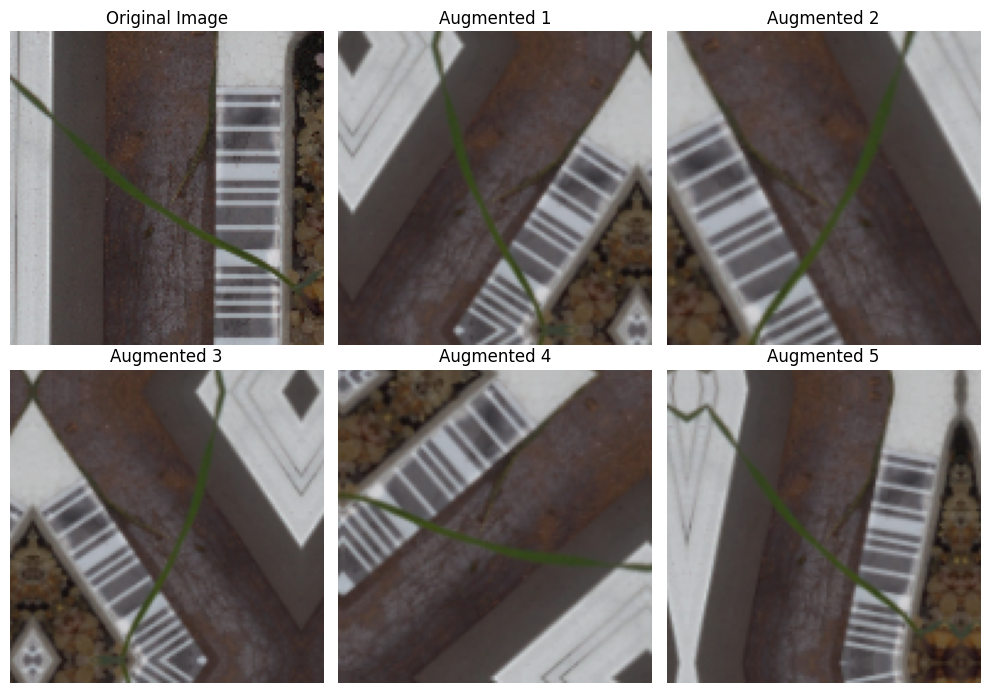

In [21]:
# Convert first image to uint8 format for augmentation
sample_image = (images[0] * 255).astype(np.uint8)

# Define the data augmentation pipeline
augmentation_pipeline = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Generate augmented samples
augmented_samples = [augmentation_pipeline(tf.expand_dims(sample_image, axis=0)) for _ in range(6)]

# Create a figure with 2 rows and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
axes = axes.flatten()

# Display the original image
axes[0].imshow(sample_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display the augmented images
for idx in range(1, 6):
    axes[idx].imshow(tf.cast(augmented_samples[idx - 1][0], tf.uint8))
    axes[idx].set_title(f"Augmented {idx}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
image_labels = [[class_names[label]] for label in labels]

mlb = MultiLabelBinarizer()
encoded_labels = mlb.fit_transform(image_labels)

print("Classes:", mlb.classes_)
print("Sample label encoding:", encoded_labels[:5])

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'ShepherdтАЩs Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Sample label encoding: [[1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]]


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (4431, 128, 128, 3)
Validation set size: (1108, 128, 128, 3)


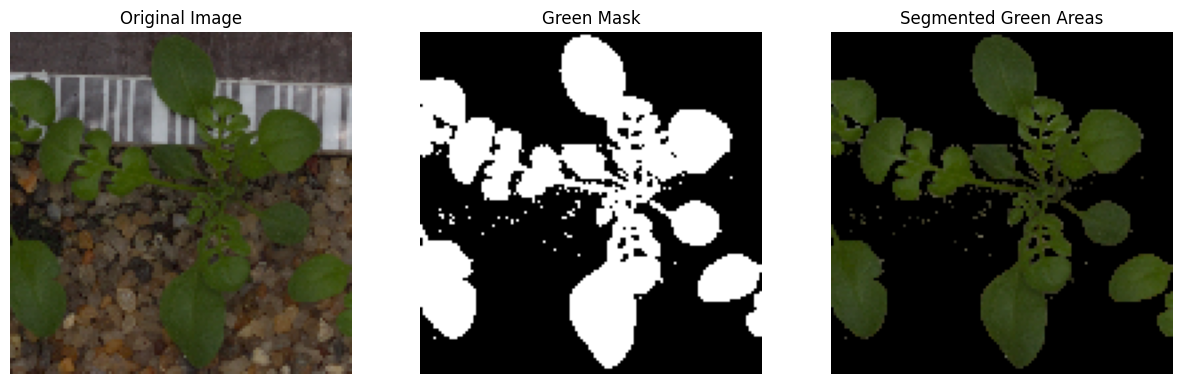

In [ ]:
import cv2

sample_img = (X_train[0] * 255).astype(np.uint8)

hsv_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)

lower_green = np.array([25, 40, 40])
upper_green = np.array([90, 255, 255])

green_mask = cv2.inRange(hsv_img, lower_green, upper_green)

segmented_img = cv2.bitwise_and(sample_img, sample_img, mask=green_mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(green_mask, cmap="gray")
axes[1].set_title("Green Mask")
axes[1].axis('off')

axes[2].imshow(segmented_img)
axes[2].set_title("Segmented Green Areas")
axes[2].axis('off')

plt.show()

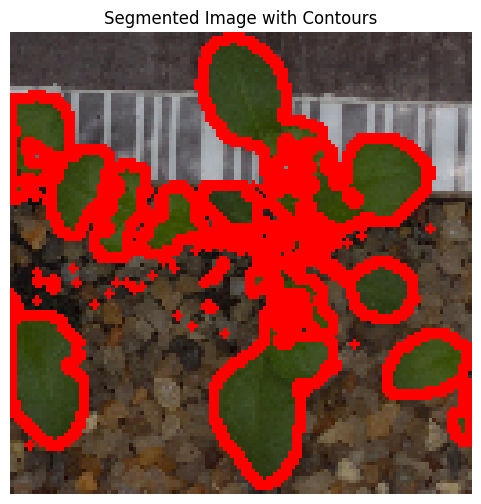

In [ ]:
contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour_img = sample_img.copy()
cv2.drawContours(contour_img, contours, -1, (255, 0, 0), 2)

plt.figure(figsize=(6,6))
plt.imshow(contour_img)
plt.title("Segmented Image with Contours")
plt.axis('off')
plt.show()

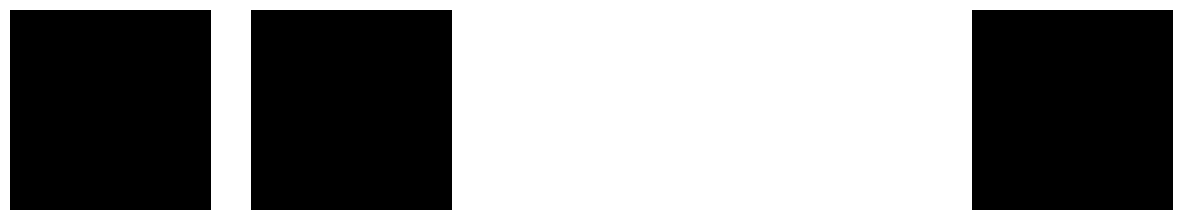

In [30]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.1)
])

augmented_batch = data_augmentation(X_train[:5])

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(augmented_batch[i])
    axes[i].axis('off')

plt.show()

In [24]:
import numpy as np

# Identify crop & weed indices
crop_indices = np.where(y_train[:, :5].sum(axis=1) > 0)[0]  # First 5 classes are crops
weed_indices = np.where(y_train[:, :5].sum(axis=1) == 0)[0]  # The rest are weeds

# Compute oversampling factor
oversample_factor = len(weed_indices) // len(crop_indices)

# Oversample crops
oversampled_crops = np.tile(X_train[crop_indices], (oversample_factor, 1, 1, 1))
oversampled_labels = np.tile(y_train[crop_indices], (oversample_factor, 1))

# Merge back with original training set
X_train_balanced = np.concatenate((X_train, oversampled_crops), axis=0)
y_train_balanced = np.concatenate((y_train, oversampled_labels), axis=0)

print("Balanced Training set size:", X_train_balanced.shape)

Balanced Training set size: (6069, 128, 128, 3)


In [29]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.arange(len(mlb.classes_)), y=np.argmax(y_train, axis=1))
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.5646186440677967, 1: 1.0490056818181819, 2: 1.3675925925925927, 3: 0.645541958041958, 4: 1.7752403846153846, 5: 0.8667840375586855, 6: 0.581496062992126, 7: 1.7838164251207729, 8: 0.7474696356275303, 9: 1.733568075117371, 10: 0.8009761388286334, 11: 1.0343137254901962}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Define CNN model
model = Sequential([
    # First Conv Block
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Third Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Fourth Conv Block
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Global Average Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output layer with sigmoid for multi-label classification
    Dense(len(mlb.classes_), activation='sigmoid')
])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,268 (1.65 MB)

 Trainable params: 431,308 (1.65 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Compile the model
model.compile(
    loss='binary_crossentropy',  # Since it's multi-label classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Reduce learning rate when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Save the best model based on validation loss
checkpoint = ModelCheckpoint('weed_detection_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train again with these callbacks
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[lr_scheduler, checkpoint])


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2170 - loss: 0.3563
Epoch 1: val_loss improved from inf to 0.43649, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.2177 - loss: 0.3558 - val_accuracy: 0.1146 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 2/20
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4660 - loss: 0.2159
Epoch 2: val_loss did not improve from 0.43649
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.4664 - loss: 0.2157 - val_accuracy: 0.1146 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 3/20
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5917 - loss: 0.1717
Epoch 3: val_loss did not improve from 0.43649
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.5919 - loss: 0.1717 - val_accuracy: 0.2022 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6582 - loss: 0.1505
Epoch 4: val_loss improved from 0.43649 to 0.39972, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6584 - loss: 0.1504 - val_accuracy: 0.2374 - val_loss: 0.3997 - learning_rate: 0.0010
Epoch 5/20
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7385 - loss: 0.1234
Epoch 5: val_loss improved from 0.39972 to 0.19792, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7386 - loss: 0.1233 - val_accuracy: 0.4585 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7669 - loss: 0.1067
Epoch 6: val_loss improved from 0.19792 to 0.12065, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7670 - loss: 0.1067 - val_accuracy: 0.6968 - val_loss: 0.1206 - learning_rate: 0.0010
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7890 - loss: 0.0954
Epoch 7: val_loss did not improve from 0.12065
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7891 - loss: 0.0954 - val_accuracy: 0.5614 - val_loss: 0.1918 - learning_rate: 0.0010
Epoch 8/20
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8218 - loss: 0.0817
Epoch 8: val_loss improved from 0.12065 to 0.10990, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8218 - loss: 0.0817 - val_accuracy: 0.7157 - val_loss: 0.1099 - learning_rate: 0.0010
Epoch 9/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8334 - loss: 0.0765
Epoch 9: val_loss did not improve from 0.10990
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8334 - loss: 0.0765 - val_accuracy: 0.6038 - val_loss: 0.2551 - learning_rate: 0.0010
Epoch 10/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8571 - loss: 0.0632
Epoch 10: val_loss improved from 0.10990 to 0.08663, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8572 - loss: 0.0632 - val_accuracy: 0.8023 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 11/20
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8707 - loss: 0.0598
Epoch 11: val_loss did not improve from 0.08663
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8707 - loss: 0.0598 - val_accuracy: 0.7419 - val_loss: 0.1024 - learning_rate: 0.0010
Epoch 12/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8854 - loss: 0.0537
Epoch 12: val_loss did not improve from 0.08663
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8855 - loss: 0.0537 - val_accuracy: 0.7455 - val_loss: 0.1164 - learning_rate: 0.0010
Epoch 13/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8957 - loss: 0.0514
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss did not improve from 0.08663
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8957 - loss: 0.0514 - val_accura

139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9068 - loss: 0.0446 - val_accuracy: 0.8303 - val_loss: 0.0849 - learning_rate: 5.0000e-04
Epoch 15/20
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9340 - loss: 0.0331
Epoch 15: val_loss improved from 0.08488 to 0.06106, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9340 - loss: 0.0331 - val_accuracy: 0.8610 - val_loss: 0.0611 - learning_rate: 5.0000e-04
Epoch 16/20
138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9376 - loss: 0.0307
Epoch 16: val_loss did not improve from 0.06106
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9376 - loss: 0.0307 - val_accuracy: 0.8520 - val_loss: 0.0671 - learning_rate: 5.0000e-04
Epoch 17/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9452 - loss: 0.0311
Epoch 17: val_loss improved from 0.06106 to 0.03852, saving model to weed_detection_model.h5


139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9452 - loss: 0.0311 - val_accuracy: 0.9152 - val_loss: 0.0385 - learning_rate: 5.0000e-04
Epoch 18/20
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9526 - loss: 0.0263
Epoch 18: val_loss did not improve from 0.03852
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9525 - loss: 0.0263 - val_accuracy: 0.8998 - val_loss: 0.0478 - learning_rate: 5.0000e-04
Epoch 19/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9546 - loss: 0.0248
Epoch 19: val_loss did not improve from 0.03852
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9546 - loss: 0.0248 - val_accuracy: 0.7852 - val_loss: 0.1124 - learning_rate: 5.0000e-04
Epoch 20/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9616 - loss: 0.0219
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: val_loss did not improve from 0.03852
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9616 - loss: 0.0220 

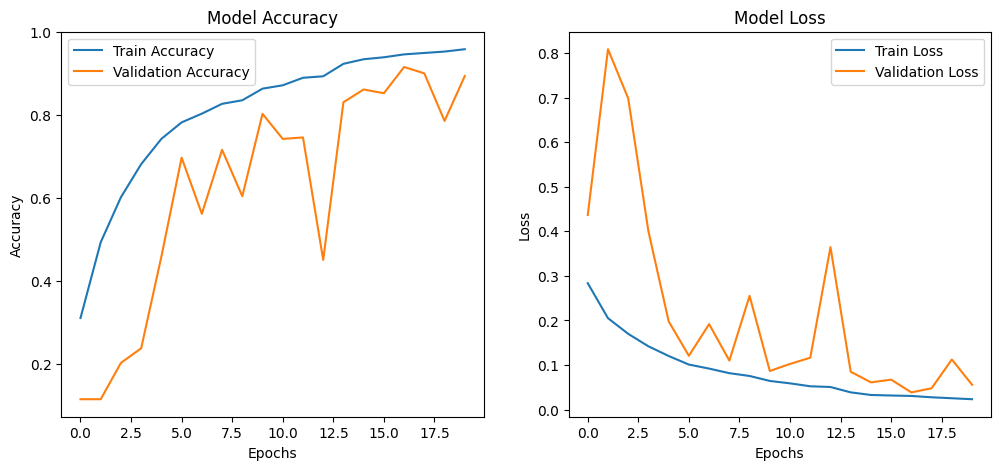

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(X_val, y_val)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9000 - loss: 0.0578
Test Accuracy: 89.35%
Test Loss: 0.0557


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


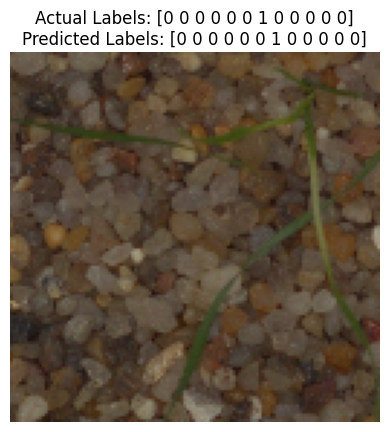

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/content/weed_detection_model.h5")

# Select a random sample from the validation set
random_idx = np.random.randint(len(X_val))
sample_image = X_val[random_idx]
true_label = y_val[random_idx]

# Predict using the model
prediction = model.predict(np.expand_dims(sample_image, axis=0))[0]
predicted_labels = (prediction > 0.5).astype(int)

# Display the image with labels
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Actual Labels: {true_label}\nPredicted Labels: {predicted_labels}")
plt.show()


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step


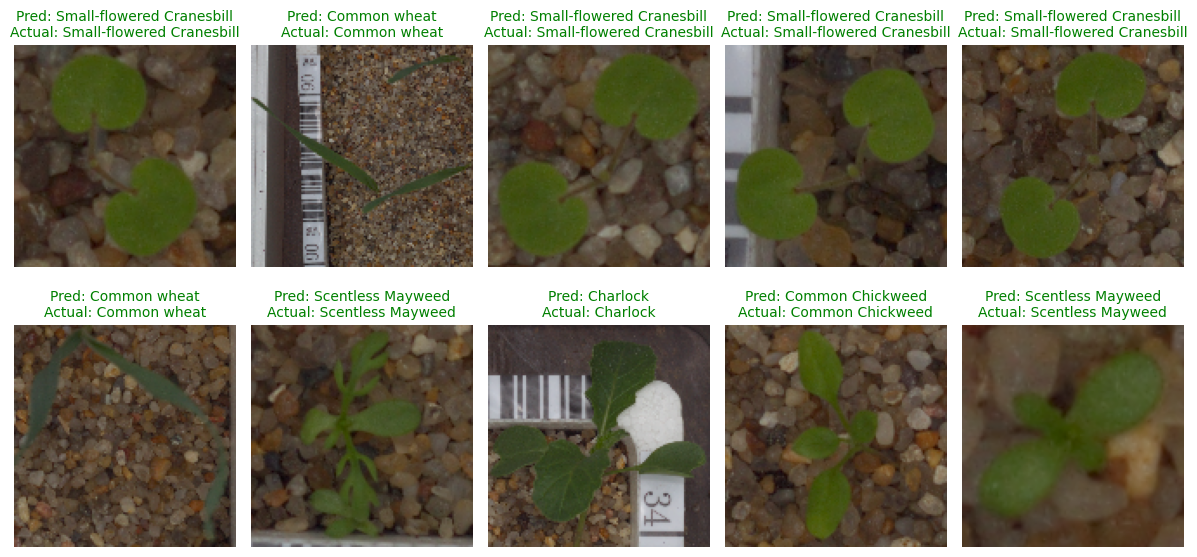

In [37]:
model = tf.keras.models.load_model("/content/weed_detection_model.h5")

# Generate predictions
predictions = model.predict(X_val)
predicted_labels = np.argmax(predictions, axis=1)

# Select random images for visualization
num_samples = min(10, len(X_val))
random_indices = np.random.choice(len(X_val), num_samples, replace=False)

# Extract selected images and labels
sample_images = X_val[random_indices]
true_labels = np.argmax(y_val[random_indices], axis=1)
predicted_class_names = [class_names[i] for i in predicted_labels[random_indices]]
actual_class_names = [class_names[i] for i in true_labels]

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.axis("off")
    title_color = "green" if predicted_class_names[i] == actual_class_names[i] else "red"
    plt.title(f"Pred: {predicted_class_names[i]}\nActual: {actual_class_names[i]}", fontsize=10, color=title_color)

plt.tight_layout()
plt.show()

In [40]:
import tensorflow as tf
from sklearn.metrics import classification_report

# Load the trained model
model = tf.keras.models.load_model("/content/weed_detection_model.h5")

# Extract the correct class names (first 12 classes)
selected_class_names = class_names[:12]

# Generate predictions
pred_probs = model.predict(X_val)
pred_classes = np.argmax(pred_probs, axis=1)

# Generate the classification report
classification_results = classification_report(y_true=y_val.argmax(axis=1),
                                               y_pred=pred_classes,
                                               target_names=selected_class_names)

print(classification_results)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
                           precision    recall  f1-score   support

              Black-grass       0.83      0.55      0.66        73
                 Charlock       1.00      0.86      0.92       100
                 Cleavers       0.98      0.95      0.97        65
         Common Chickweed       0.95      0.99      0.97       141
             Common wheat       0.91      0.93      0.92        45
                  Fat Hen       1.00      0.97      0.99       112
         Loose Silky-bent       0.77      0.94      0.84       127
                    Maize       0.91      0.96      0.93        50
        Scentless Mayweed       0.83      0.99      0.90       113
       ShepherdтАЩs Purse       0.86      0.72      0.79        61
Small-flowered Cranesbill       1.00      0.96      0.98       115
               Sugar beet       0.98      0.96      0.97       106

                 accuracy                           0.92      1108
                macr

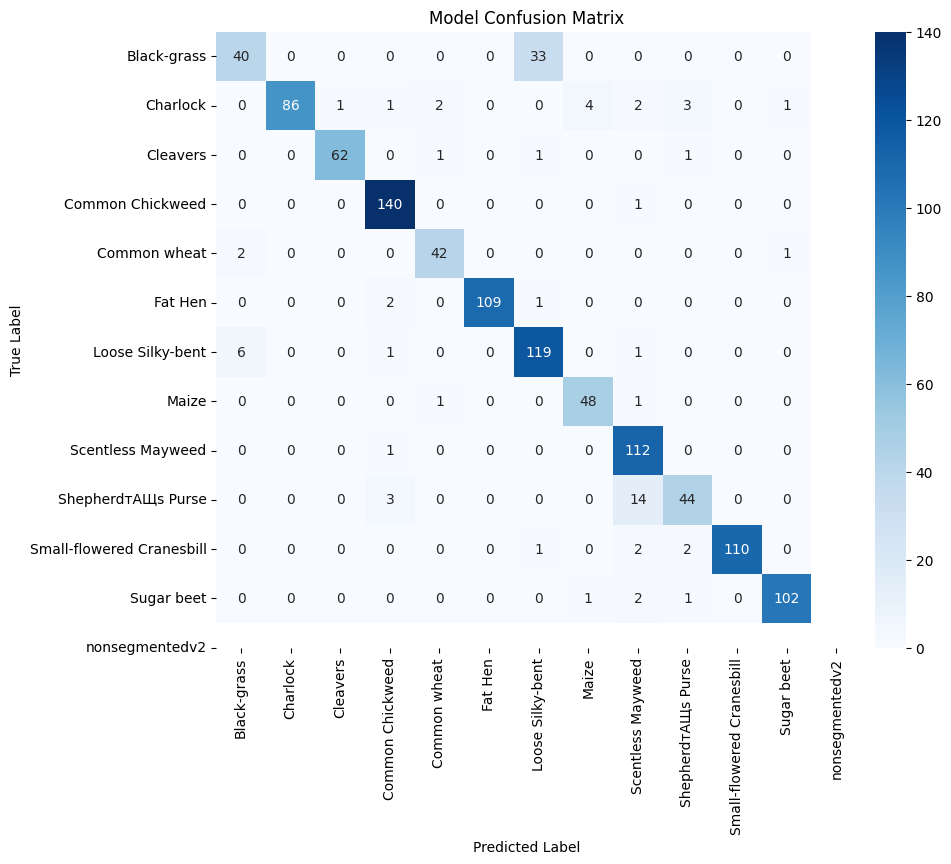

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_val.argmax(axis=1), y_pred=pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

In [44]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Compute AUC score
auc_score = roc_auc_score(y_val, pred_probs, multi_class="ovr")
print(f"Overall AUC Score: {auc_score:.4f}")

Overall AUC Score: 0.9962


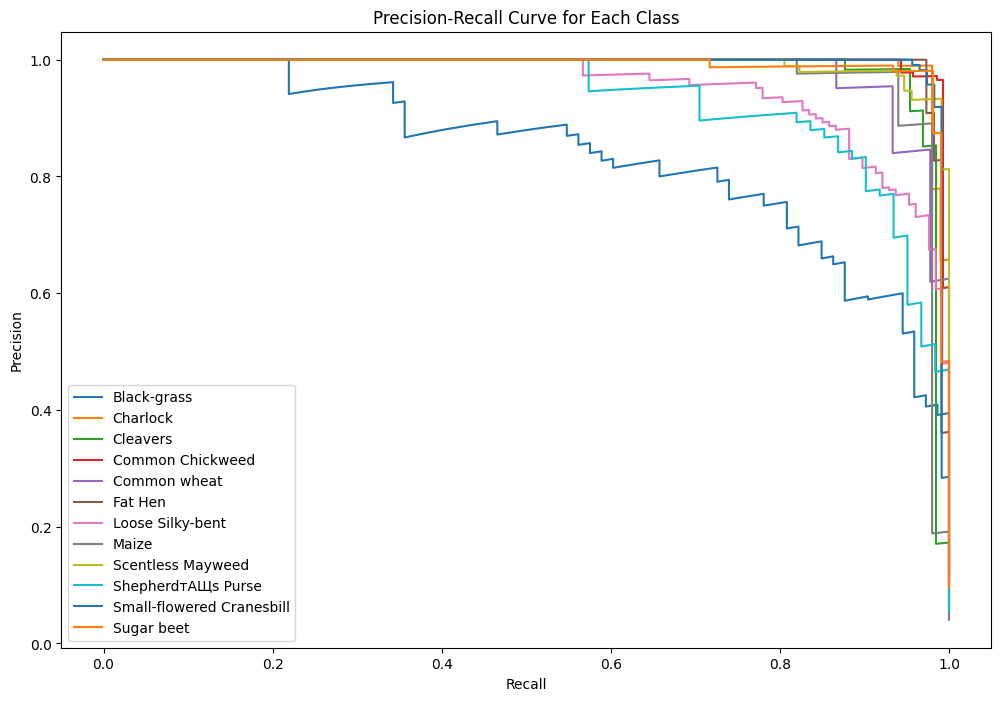

In [45]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))

for i in range(len(class_names[:12])):
    precision, recall, _ = precision_recall_curve(y_val[:, i], pred_probs[:, i])
    plt.plot(recall, precision, label=class_names[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class")
plt.legend()
plt.show()